In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# 프로젝트 진행 방법
## Attention-Guided Discriminative Region Localization for Bone Age Assessment
: 본 논문 Phase 1에서는 InceptionNet V3와 CAM으로 Localization하여 Attention guided RoIs를 Crop 했지만
본 프로젝트에서는 EfficientNet B3와 더 나은 성능을 위해 Grad-CAM을 사용할 예정이다.
 또한 Phase 2에서는 Xception 대신 EfficientNet B3으로 학습하여 Bone age를 예측할 예정이다.
 
 github : https://github.com/chenchao666/Bone-Age-Assessment
 
 paper : https://arxiv.org/abs/2006.00202

1. 새 데이터로 학습
2. 매 epoch마다 저장
3. 마지막에 그래프
4. 꺽이는 epoch 선택하여 test
5. RoI 확인
6. Threshold와 손 최고 Area 결정
7. 2단계 학습 후 성능 확인
8. 블로그 및 ppt 자료 만들기

In [2]:
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from skimage.measure import label, regionprops
from tensorflow import keras
from scipy import ndimage

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import random
import cv2
import os
import scipy

BATCH_SIZE = 1
EPOCHS = 50
#base_dir = "C:/Users/yhu04/archive/"
base_dir = '/content/gdrive/MyDrive/Colab Notebooks/archive/'

## 1. 데이터 전처리
1. CLAHE
2. training-dataset.csv -> male FALSE -> 0, TRUE -> 1


#### Image
1. Resize : Height, Width -> 300 x 300
2. Normalization : [0, 255] -> [0, 1]

#### Lable (Bone Age)
영상 데이터가 해당 뼈 나이에 정확히 수렴하지 않기 때문에, soft label로 ont-hot encoding을 해야한다.

Number of Bone Age Training Set : 12611
Male : Female = 6833 : 5778


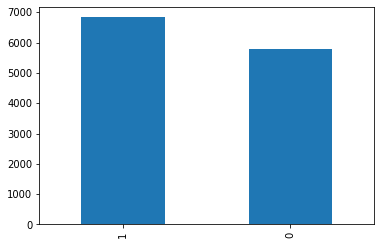

Number of Bone Age Validation Set : 1425
Male : Female = 773 : 652


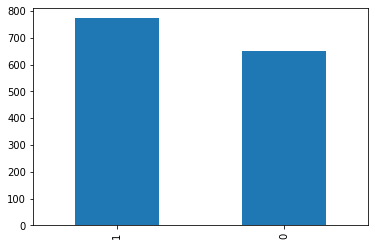

Number of Bone Age Test Set : 200
Male : Female = 100 : 100


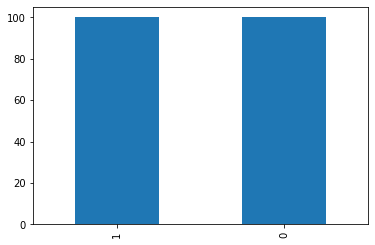

In [3]:
folder_name = ["Bone Age Training Set", "Bone Age Validation Set", "Bone Age Test Set"]

for i, name in enumerate(folder_name):
    csv = pd.read_csv(base_dir + f"{name}/{name}.csv")
    csv.reset_index(drop=True, inplace = True)        

    # 1. 성별 숫자로 변환
    csv["male"] = csv["male"].apply(lambda x : 1 if x == True else 0 if x == False else 0)

    count_sex = pd.value_counts(csv['male'].values, sort=True)
    print(f"Number of {name} : {len(csv)}")
    print(f"Male : Female = {count_sex.iloc[0]} : {count_sex.iloc[1]}")
    plt.figure(i)
    count_sex.plot.bar()
    plt.show()

    csv.to_csv(base_dir + f"{name}/{name}.csv", index = False)

In [4]:
class Dataset_Generator():
    def __init__(self, phase, epochs = EPOCHS, base_dir = base_dir):
        self.base_dir = base_dir
        self.phase = phase
        if phase in [1.1, 1.2]:
            self.folder_name = ""
        elif phase == 2:
            self.folder_name = "_2"
        self.epochs = epochs


    def _softlabel(self, age):
        softlabel = np.zeros(240)
        l = 50
        for i in range(1, 241):
            softlabel[i-1] = 1.0 - np.abs(i - age)/l
        softlabel = np.maximum(softlabel, 0)
        return np.asarray([softlabel], dtype = np.float)

    def _gausslabel(self, age):
        gausslabel = np.zeros(240)
        sigma=15.0

        for i in range(1, 241):
            gausslabel[i-1] = 1/(np.sqrt(2 * 3.141592) * sigma) *(np.exp(-(i - age)**2/(2.0 * sigma ** 2)))
        return np.asarray([gausslabel], dtype = np.float)

    def _Image_preprocessor(self, image, sex, age):
        if self.phase == 1.1:
            image = cv2.resize(image, (300, 300))
            image = np.reshape(image, ((1, )  + image.shape))
            age = self._softlabel(age)
            return (image/255, age)
        
        elif self.phase == 1.2:
            image = cv2.resize(image, (560, 560))
            image = np.reshape(image, ((1, )  + image.shape))
            age = self._softlabel(age)
            return (image/255, age)

        elif self.phase == 2:
            image = cv2.resize(image, (560, 560))
            image = np.reshape(image, ((1, )  + image.shape))
            age = self._gausslabel(age)
            sex = np.reshape(sex, (1,)) 
            return ([image/255, sex], age)

    def train_generator(self):
        csv = pd.read_csv(self.base_dir + f"Bone Age Training Set{self.folder_name}/Bone Age Training Set.csv")
        csv.reset_index(drop=True, inplace = True)
        for _ in range(self.epochs):
            for i, file_name in enumerate(csv["id"]):
                img = cv2.imread(self.base_dir + f"Bone Age Training Set{self.folder_name}/Bone Age Training Set/{file_name}.png")
                age = np.array(csv.iloc[i, 1], dtype = "float32")
                sex = np.array(csv.iloc[i, 2], dtype = "float32")
                yield self._Image_preprocessor(img, sex, age)
            
    def valid_generator(self):
        csv = pd.read_csv(self.base_dir + f"Bone Age Validation Set{self.folder_name}/Bone Age Validation Set.csv")
        csv.reset_index(drop=True, inplace = True)
        for _ in range(self.epochs):
            for i, file_name in enumerate(csv["id"]):
                img = cv2.imread(self.base_dir + f"Bone Age Validation Set{self.folder_name}/Bone Age Validation Set/{file_name}.png")
                age = np.array(csv.iloc[i, 1], dtype = "float32")
                sex = np.array(csv.iloc[i, 2], dtype = "float32")
                yield self._Image_preprocessor(img, sex, age)
            
    def test_generator(self):
        csv = pd.read_csv(self.base_dir + f"Bone Age Test Set{self.folder_name}/Bone Age Test Set.csv")
        csv.reset_index(drop=True, inplace = True)
        for i, file_name in enumerate(csv["id"]):
            img = cv2.imread(self.base_dir + f"Bone Age Test Set{self.folder_name}/Bone Age Test Set/{file_name}.png")
            age = np.array(csv.iloc[i, 1], dtype = "float32")
            sex = np.array(csv.iloc[i, 2], dtype = "float32")
            yield self._Image_preprocessor(img, sex, age)

## 2. Training

In [5]:
class MAE_RegulationLoss(tf.losses.Loss):
    def __init__(self, sigma = 15.0, lamda = 0.55):
        super(MAE_RegulationLoss, self).__init__(reduction="auto", name="MAE_RegulationLoss")
        self.sigma = sigma
        self.lamda = lamda
        self.k = tf.cast([i for i in range(1, 241)], dtype = tf.float32)
        self.epsilon = 1e-7

    def call(self, y_true, y_pred):
        """
        # Loss = Loss_reg + MAE
        1. Loss_reg
        G : Gaussian Distribution
        -reduce_sum(G * ln(y_pred/G))

        2. MAE
        y_pred = sum(k * p_k), k = 1, 2, 3, ..., 240
        MAE = |y_pred - y_true|
        """
        
        G = 1/(tf.math.sqrt(2 * 3.141592) * self.sigma) * tf.math.exp((-(self.k - y_true) ** 2)/(2.0 * (self.sigma ** 2))) + self.epsilon
        Loss_reg = - tf.reduce_sum(G * tf.math.log((y_pred + self.epsilon)/ G), axis = -1)
        
        y_true = tf.reduce_sum(y_true * self.k, axis=-1)
        y_pred = tf.reduce_sum(y_pred * self.k, axis=-1)
        MAE = tf.keras.losses.mean_absolute_error(y_true, y_pred)
        
        loss = MAE + self.lamda * Loss_reg
        return loss

In [6]:
def MAE_(y_true, y_pred):
    return tf.math.abs(tf.argmax(y_true[0]) - tf.argmax(y_pred[0]))

In [7]:
def create_model(phase):
    if phase == 1.1:
        h, w = 300, 300
        loss_fn = 'mean_absolute_error'
        lr = 0.0005

    elif phase == 1.2:
        h, w = 560, 560
        loss_fn = 'mean_absolute_error'
        lr = 0.0005

    elif phase == 2:
        h, w = 560, 560
        loss_fn = MAE_RegulationLoss()
        lr = 0.0005
        
    else:
        print("Error Phase number")
        return -1

    image = Input(shape=(h, w, 3), name='image')
    base_model = tf.keras.applications.EfficientNetB3(input_shape = [h, w, 3],
                                                   include_top = False,
                                                   weights = 'imagenet',
                                                   )
    base_model.trainable = True
    x = base_model(image, training = True)
    
    if phase in [1.1, 1.2]:
        x = keras.layers.GlobalAveragePooling2D(name = "GAP")(x)
        output = tf.keras.layers.Dense(240, activation = "linear", name = "Output_layer")(x)
        model = tf.keras.Model(inputs = image, outputs = output)

    elif phase == 2:
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Flatten(name = "Flatten")(x)
        gender = Input(shape=(1, ), dtype = "float32", name='gender')
        gender_embedding = Dense(32, activation = "relu", name = "Gender_Embedding")(gender)
        x = tf.keras.layers.Concatenate(axis=1, name = "Concatenate")([x, gender_embedding])
        output = tf.keras.layers.Dense(240, activation = "softmax", name = "Output_layer")(x)
        model = tf.keras.Model(inputs = [image, gender], outputs = output)

    Adam = tf.keras.optimizers.Adam(learning_rate = lr,
                                    beta_1 = 0.9, 
                                    beta_2 = 0.999)

    model.compile(optimizer = Adam, loss = loss_fn, metrics = [MAE_])
    return model

## 2.1. Phase 1: Attention Guided RoIs Localization by Grad-CAM

### 2.1.1. Training for Localization of Hand Region

In [ ]:
# 1.1. Training for Localization of Hand Region
data = Dataset_Generator(phase = 1.1)

#del model
model = create_model(phase = 1.1)
model.summary()
 
# Training
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath = base_dir +'Phase_1.1_{epoch}.h5',
                                                  monitor = "val_loss",
                                                  save_best_only = False,
                                                  verbose = 1
                                                 ),
                  keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                patience = 5,
                                                min_delta = 0.01,
                                               ),
                 ]
 
 
# When training stopped Use this code.
#model.load_weights(base_dir +'Phase_1.1_2.h5')
 
history = model.fit(data.train_generator(),
                    steps_per_epoch = 12611,
                    validation_data = data.valid_generator(),
                    validation_steps = 1425,
                    callbacks = callbacks_list,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                   )

43941888/43941136 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 300, 300, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1536)              0         
_________________________________________________________________
Output_layer (Dense)         (None, 240)               368880    
Total params: 11,152,415
Trainable params: 11,065,112
Non-trainable params: 87,303
_________________________________________________________________
Epoch 1/50
12611/12611 [==============================] - 8978s 710ms/step - loss: 0.1232 - MAE_1: 17.7671 - val_loss: 0.0967 - val_MAE_1: 13.6140

Epoch 00001: saving model to 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
12611/12611 [==============================] - 9010s 714ms/step - loss: 0.0947 - MAE_1: 12.8463 - val_loss: 0.0898 - val_MAE_1: 12.5228

Epoch 00002: saving model to /content/gdrive/MyDrive/Colab Notebooks/archive/Phase_1.1_2.h5
Epoch 3/50
12611/12611 [==============================] - 7583s 601ms/step - loss: 0.0853 - MAE_1: 11.5552 - val_loss: 0.0879 - val_MAE_1: 12.4218

Epoch 00003: saving model to /content/gdrive/MyDrive/Colab Notebooks/archive/Phase_1.1_3.h5
Epoch 4/50
12611/12611 [==============================] - 6996s 555ms/step - loss: 0.0790 - MAE_1: 10.6588 - val_loss: 0.0857 - val_MAE_1: 11.8968

Epoch 00004: saving model to /content/gdrive/MyDrive/Colab Notebooks/archive/Phase_1.1_4.h5
Epoch 5/50
12611/12611 [==============================] - 7254s 575ms/step - loss: 0.0742 - MAE_1: 9.9187 - val_loss: 0.0931 - val_MAE_1: 12.8716

Epoch 00005: saving model to /content/gdrive/MyDrive/Colab Notebooks/archive/Phase_1.1_5.h5
Epoch 6/50
12611/12611 [=================

In [10]:
# 모델 성능 테스트
data = Dataset_Generator(phase = 1.1)
model = create_model(phase = 1.1)
model.load_weights(base_dir +'Phase_1.1_4.h5')

score = model.evaluate(data.test_generator(),
                       batch_size = BATCH_SIZE)

print('Test loss:', score[0])
print('Test MAE:', score[1])

200/200 [==============================] - 152s 674ms/step - loss: 0.0884 - MAE_: 12.1700
Test loss: 0.08842471241950989
Test MAE: 12.170000076293945


실제 : 168, 예측 : 171
실제 : 169, 예측 : 165
실제 : 72, 예측 : 44
실제 : 152, 예측 : 130
실제 : 134, 예측 : 112
실제 : 61, 예측 : 62
실제 : 146, 예측 : 137
실제 : 135, 예측 : 130
실제 : 177, 예측 : 155
실제 : 198, 예측 : 188
실제 : 164, 예측 : 160
실제 : 120, 예측 : 85
실제 : 161, 예측 : 154
실제 : 184, 예측 : 165
실제 : 148, 예측 : 137
실제 : 140, 예측 : 137
실제 : 191, 예측 : 173
실제 : 150, 예측 : 137
실제 : 138, 예측 : 124
실제 : 167, 예측 : 175
실제 : 165, 예측 : 171


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()


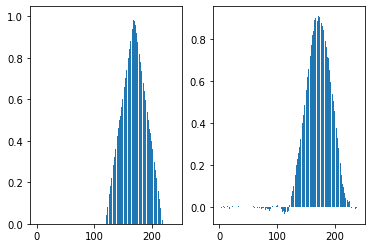

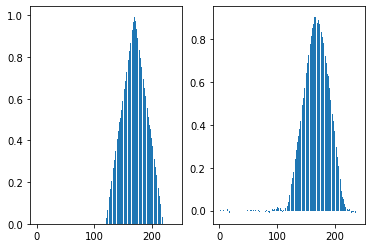

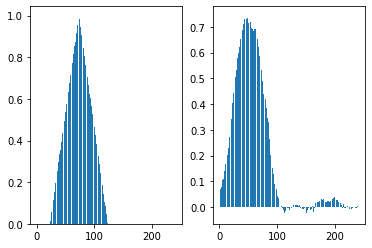

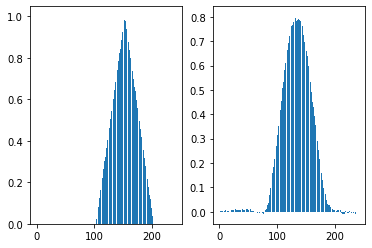

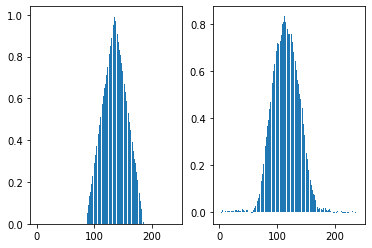

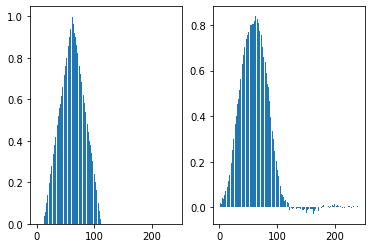

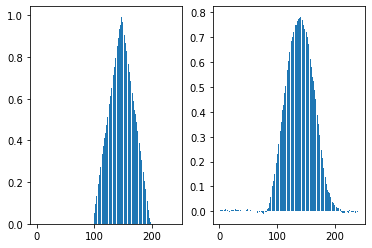

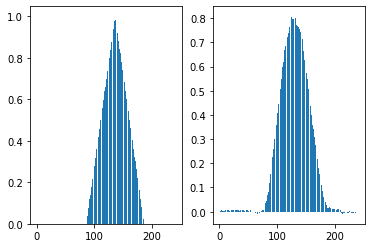

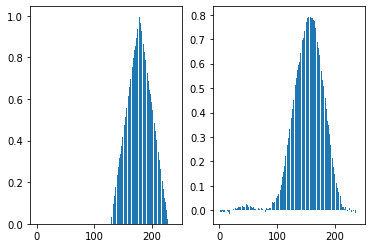

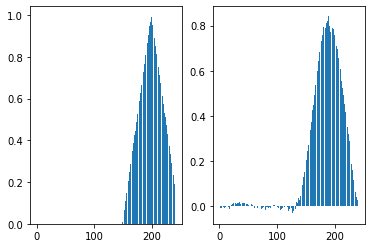

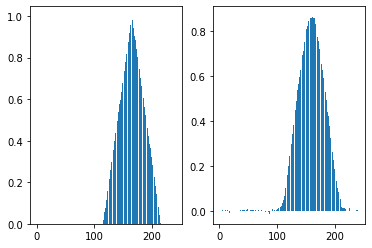

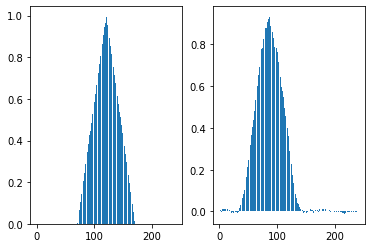

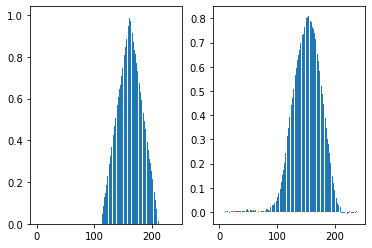

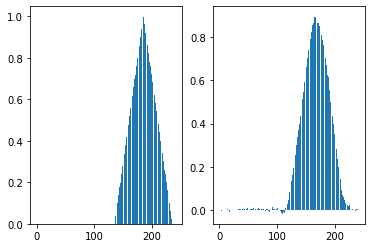

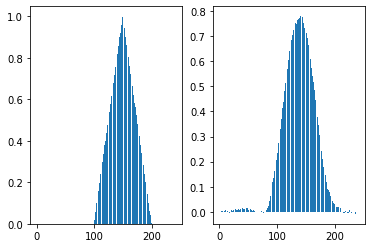

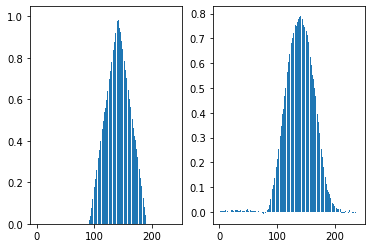

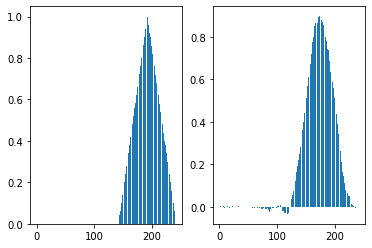

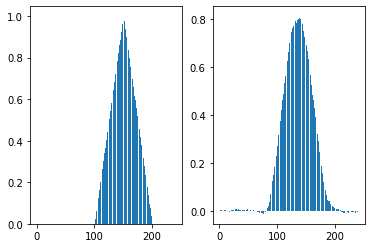

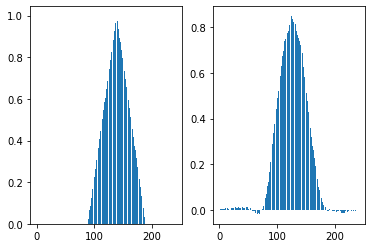

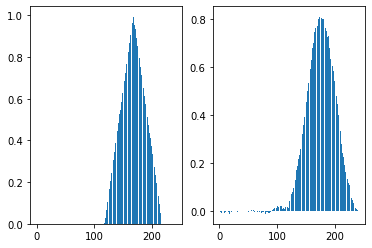

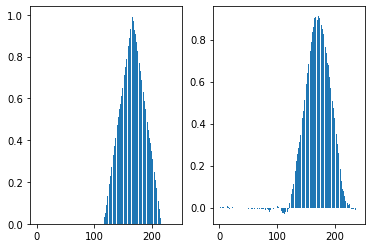

In [11]:
data = Dataset_Generator(phase = 1.1)
#model = create_model(phase = 1.1)
#model.load_weights(base_dir +'Phase_1.1.h5')

k = [i for i in range(1, 241)]

for i, test in enumerate(data.test_generator()):
    #pred = inference_model.predict(test[0])
    pred = model.predict(test[0])
    print(f"실제 : {tf.argmax(test[1][0])}, 예측 : {tf.argmax(pred[0])}")
    plt.figure(i)
    plt.subplot(1,2,1).bar(k ,test[1][0])
    plt.subplot(1,2,2).bar(k ,pred[0])
    #print(pred[0])
    if i == 20:
        break
plt.show()

### 2.1.2. Training for Localization of Region-1 and Region-2

In [ ]:
# 1.2. Training for Localization of Region-1 and Region-2
del data
data = Dataset_Generator(phase = 1.2)

del model
model = create_model(phase = 1.2)
model.summary()
 
# Training
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath = base_dir +'Phase_1.2_{epoch}.h5',
                                                  monitor = "val_loss",
                                                  save_best_only = False,
                                                  verbose = 1
                                                 ),
                  keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                                patience = 5,
                                                min_delta = 0.01,
                                               ),
                 ]
 
 
# When training stopped Use this code.
#model.load_weights(base_dir +'Phase_1.2_{}.h5')
 
history = model.fit(data.train_generator(),
                    steps_per_epoch = 12611,
                    validation_data = data.valid_generator(),
                    validation_steps = 1425,
                    callbacks = callbacks_list,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                   )

In [12]:
# 모델 성능 테스트
data = Dataset_Generator(phase = 1.2)
model = create_model(phase = 1.2)
model.load_weights(base_dir +'Phase_1.2_2.h5')

score = model.evaluate(data.test_generator(),
                       batch_size = BATCH_SIZE)

print('Test loss:', score[0])
print('Test MAE:', score[1])

200/200 [==============================] - 18s 71ms/step - loss: 0.0783 - MAE_: 10.3400
Test loss: 0.07826358079910278
Test MAE: 10.34000015258789


실제 : 168, 예측 : 182
실제 : 169, 예측 : 182
실제 : 72, 예측 : 63
실제 : 152, 예측 : 137
실제 : 134, 예측 : 122
실제 : 61, 예측 : 43
실제 : 146, 예측 : 159
실제 : 135, 예측 : 125
실제 : 177, 예측 : 169
실제 : 198, 예측 : 189
실제 : 164, 예측 : 158
실제 : 120, 예측 : 86
실제 : 161, 예측 : 147
실제 : 184, 예측 : 182
실제 : 148, 예측 : 152
실제 : 140, 예측 : 141
실제 : 191, 예측 : 189
실제 : 150, 예측 : 153
실제 : 138, 예측 : 126
실제 : 167, 예측 : 171
실제 : 165, 예측 : 171


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


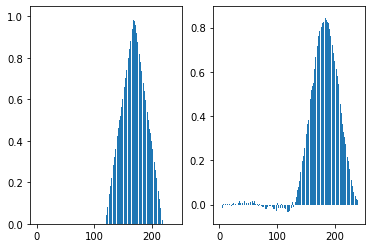

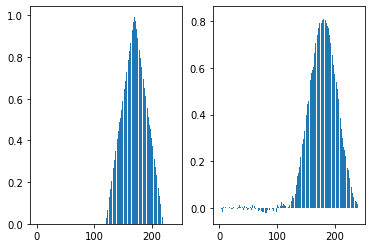

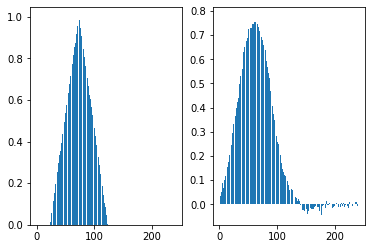

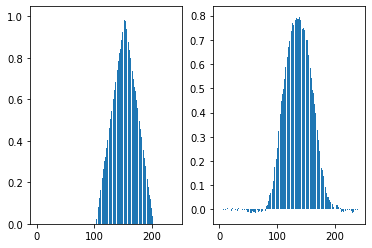

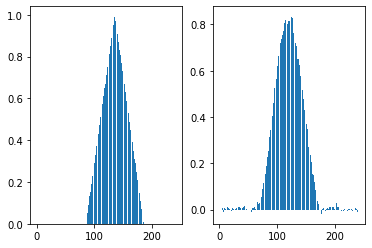

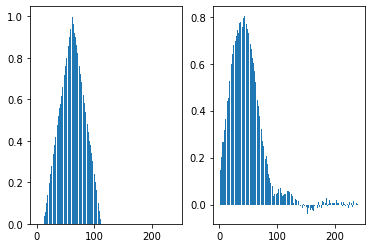

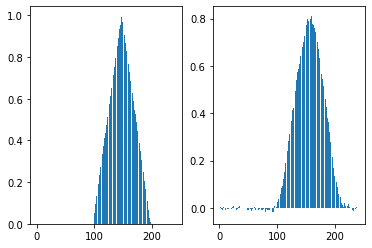

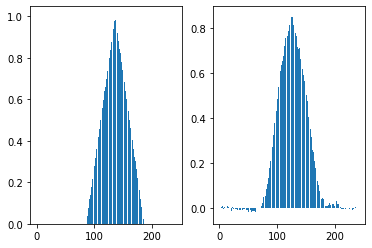

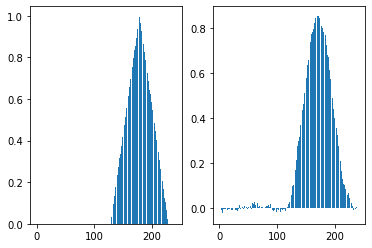

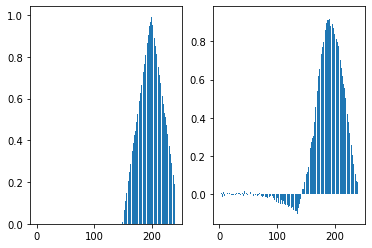

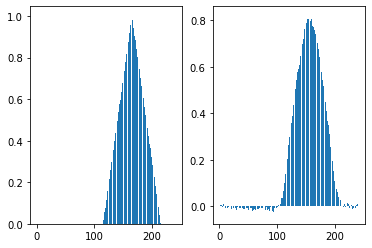

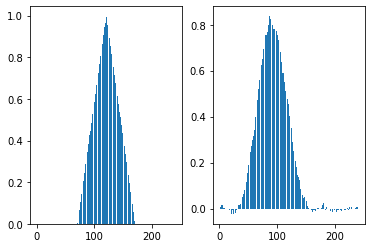

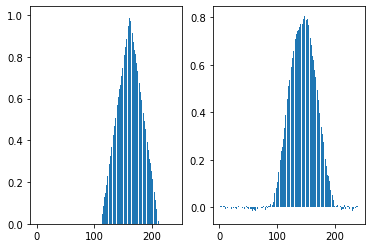

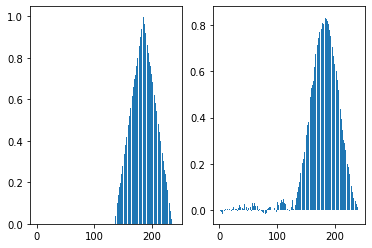

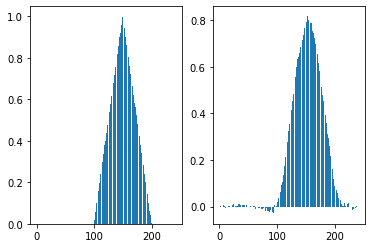

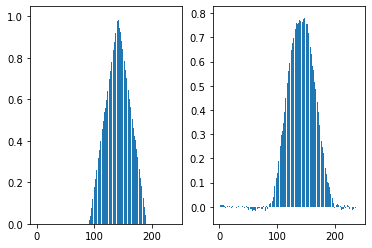

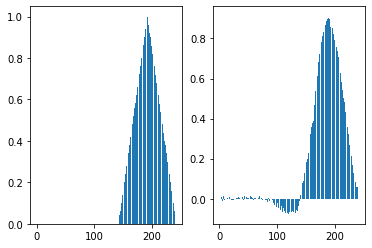

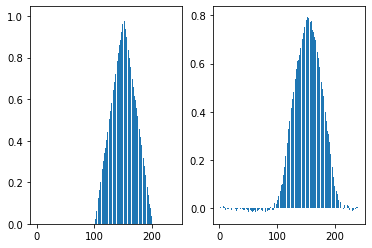

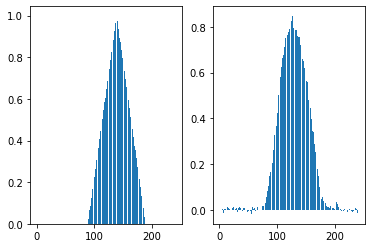

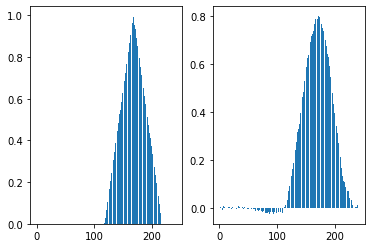

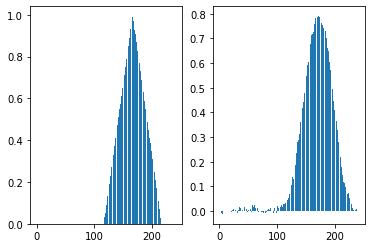

In [13]:
data = Dataset_Generator(phase = 1.2)
#model = create_model(phase = 1.2)
#model.load_weights(base_dir +'Phase_1.2.h5')

for i, test in enumerate(data.test_generator()):
    pred = model.predict(test[0])
    
    print(f"실제 : {tf.argmax(test[1][0])}, 예측 : {tf.argmax(pred[0])}")
    plt.figure(i)
    plt.subplot(1,2,1).bar(k ,test[1][0])
    plt.subplot(1,2,2).bar(k ,pred[0])
    #print(pred[0])
    if i == 20:
        break
plt.show()

### 2.1.3. Visualization Hand, Region-1 and Region-2

납글자 마킹 조심

In [8]:
#####################
# Grad-CAM Function #
#####################

# 범위 : [예측 나이 -1, 예측 나이 +1]
# 코드 출처 : https://keras.io/examples/vision/grad_cam/#the-gradcam-algorithm
def generate_gradcam(input, model, phase):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer("GAP").input, model.output]
    )
    last_conv_layer_output, preds = grad_model(input)
    pred_age = tf.argmax(preds[0])
    #age_range = [pred_age - 1 , pred_age, pred_age +1]
    age_range = [i for i in range(pred_age - 3, pred_age + 4)]

    if phase == 0:
        feature_size = 10
        size = 300
    else:
        feature_size = 18
        size = 560

    heatmap_fin = np.zeros([feature_size, feature_size], dtype = "float32")
    for i in age_range:
        if i >= 0:
            with tf.GradientTape() as tape:
                last_conv_layer_output, preds = grad_model(input)    
                class_channel = preds[:, i]

            grads = tape.gradient(class_channel, last_conv_layer_output)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
            last_conv_layer_output = last_conv_layer_output[0]
            heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
            heatmap = tf.squeeze(heatmap)
            heatmap = tf.maximum(heatmap, 0)
            heatmap = heatmap.numpy()
            heatmap_fin += heatmap
        
    heatmap = cv2.resize(heatmap_fin, (size, size)) 
    heatmap = heatmap / heatmap.max()
    return heatmap, pred_age

In [9]:
################
# Bounding Box #
################
# https://cumulu-s.tistory.com/38?category=888508
def Localization(cam, threshold):
    labeled, nr_objects = ndimage.label(cam > threshold)
    props = regionprops(labeled)
    
    # 가장 큰 박스 찾기
    RoI = []
    max_ = 0
    for i, b in enumerate(props):
        area = b.bbox_area
        if area > max_:
            max_ = area
            RoI = b.bbox # (min_row, min_col, max_row, max_col)

    return RoI[0], RoI[2], RoI[1], RoI[3]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


실제 나이 : 168.93, 예측 나이 : 171
실제 나이 : 169.65, 예측 나이 : 157
실제 나이 : 73.26, 예측 나이 : 63
실제 나이 : 152.86, 예측 나이 : 159
실제 나이 : 135.46, 예측 나이 : 126


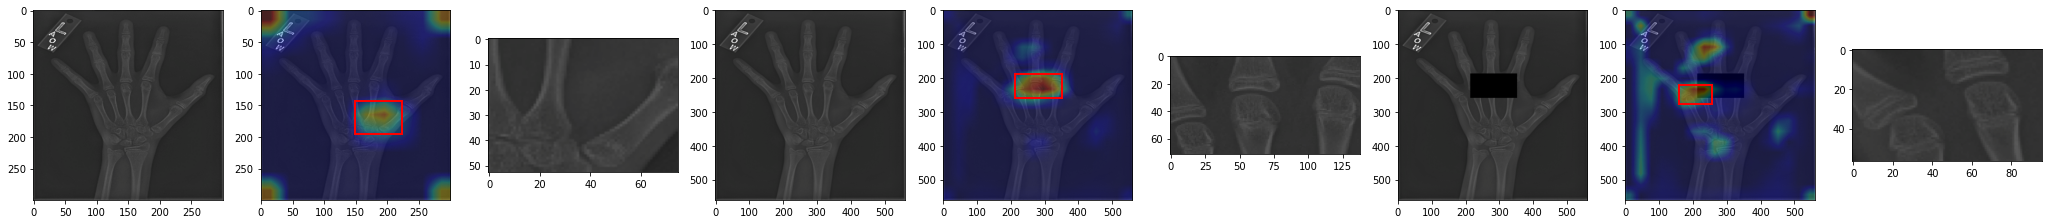

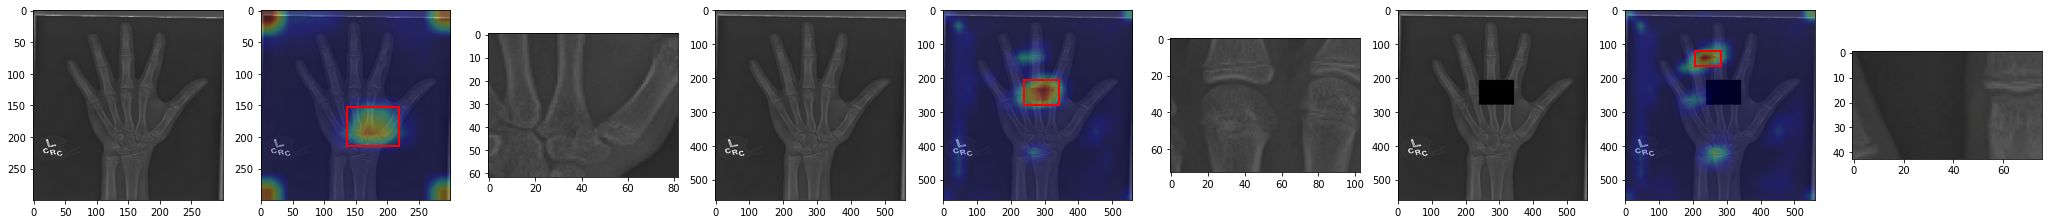

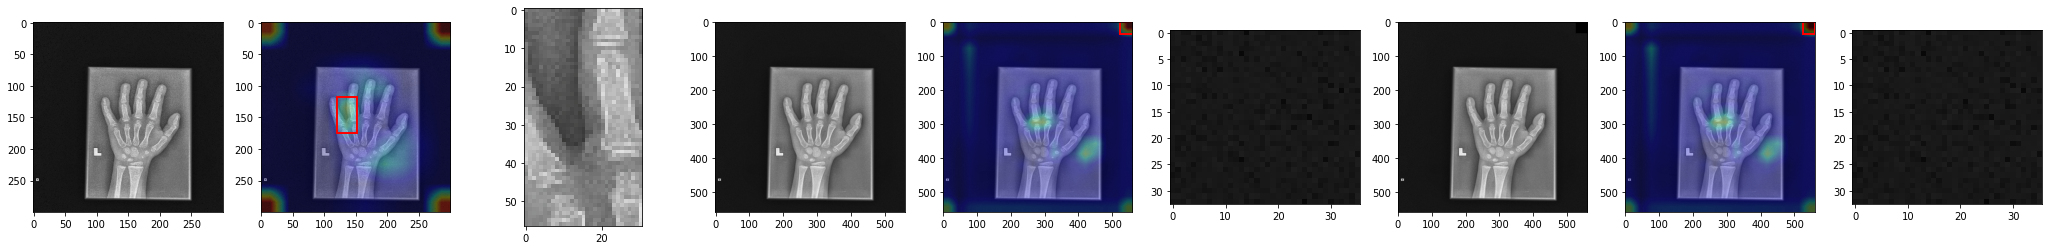

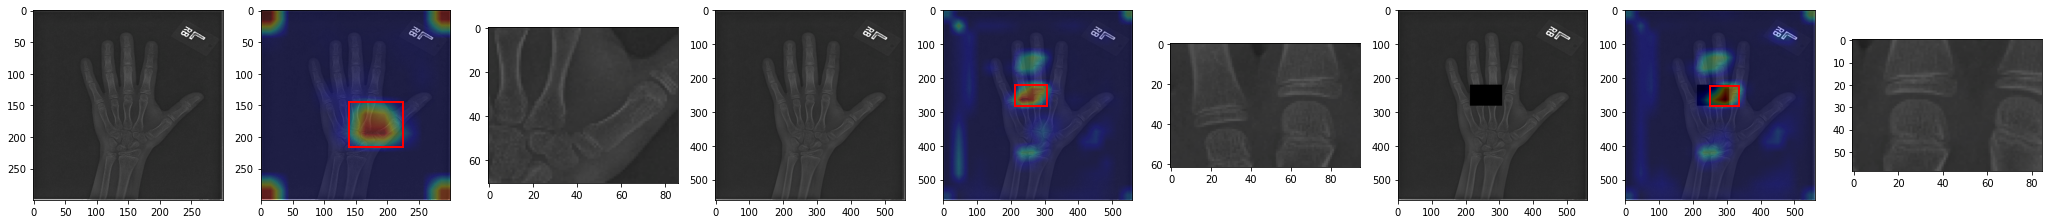

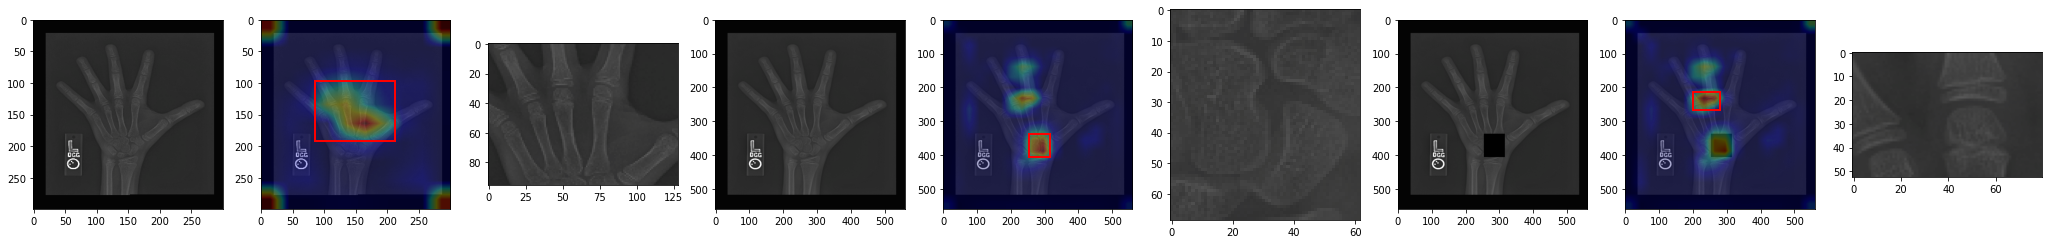

In [14]:
#############################################
# Visualization Hand, Region-1 and Region-2 #
#############################################
#del model

# 1. Load model weights
model_1 = create_model(1.1)
model_1.load_weights(base_dir +'Phase_1.1_4.h5')

model_2 = create_model(1.2)
model_2.load_weights(base_dir +'Phase_1.2_2.h5')

model = [model_1, model_2, model_2]

sample = 5
plt.close()


# 2. Threshold for Activation map
"""
In paper,
1. Hand : T = 20 in [0, 255] -> T = 20/255 in [0, 1]
2. Region-1 and Region-2 : T = 50 in [0, 255] -> T = 50/255 in [0, 1]
Failed.
"""
threshold = [0.3, 0.50, 0.50]

# 3. CSV file
csv = pd.read_csv(base_dir + f"Bone Age Test Set/Bone Age Test Set.csv")
csv.reset_index(drop=True, inplace = True)

# 4. Visualize
for i, file_name in enumerate(csv["id"]):
    original_image = cv2.imread(base_dir + f"Bone Age Test Set/Bone Age Test Set/{file_name}.png")
    #original_image = original_image/255.
    
    real_age = csv.iloc[i, 1]
    fig = plt.figure(i, figsize = (36, 4))
    
    for j in [0, 1, 2]:
        # 4.1. Input Image : 0 - Hand, 1 - Region-1, 2 - Region-2
        if j == 0:
            image = cv2.resize(original_image, (300, 300))
            copy_image = image.copy()
            image = np.reshape(image, ((1, )  + image.shape))
        elif j == 1:
            image = cv2.resize(original_image, (560, 560))
            copy_image = image.copy()
            image = np.reshape(image, ((1, )  + image.shape))
        fig.add_subplot(1, 9, 3*j+1).imshow(image[0])

        # 4.2. Find RoI
        grad_cam, pred_age = generate_gradcam(image, model[j], j)
        min_y, max_y, min_x, max_x = Localization(grad_cam, threshold[j])
        rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, linewidth = 2, edgecolor = 'red', facecolor = 'none')
        #print(f"{min_y}, {max_y}, {min_x}, {max_x} 넓이 : {(max_x - min_x) * (max_y - min_y)}")

        fig.add_subplot(1, 9, 3*j+2).imshow(image[0])
        fig.add_subplot(1, 9, 3*j+2).imshow(grad_cam, cmap = 'jet', alpha = 0.3)
        fig.add_subplot(1, 9, 3*j+2).add_patch(rect)

        # 4.3. Crop RoI from input image
        fig.add_subplot(1, 9, 3*j+3).imshow(copy_image[min_y : max_y, min_x : max_x])

        # 4.4. Postprecessing for Region-2
        if j == 1:
            image = image[0]
            image[min_y : max_y, min_x : max_x] = 0
            image = np.reshape(image, ((1, )  + image.shape))
    
    print(f"실제 나이 : {real_age}, 예측 나이 : {pred_age}")
    
    fig.show()
    if i == sample-1:
        break

del model_1, model_2, model, csv

## 2.2. Phase 2 : Bone Age Expectation Regression


In [ ]:
######################
# Generation Dataset #
######################

# 0. Threshold
threshold = [0.3, 0.90, 0.90]

# 1. 모델 로드
model_1 = create_model(phase = 1.1)
model_1.load_weights(base_dir +'Phase_1.1_2.h5')

model_2 = create_model(phase = 1.2)
model_2.load_weights(base_dir +'Phase_1.2_2.h5')

model = [model_1, model_2, model_2]

# 2. columns -> 좌표 저장법 : y_min, y_max, x_min, x_max
columns = ['id' , 'boneage', 'male', 
           'Hand min y', 'Hand max y', 'Hand min x', 'Hand max x',
           'RoI_1 min y', 'RoI_1 max y', 'RoI_1 min x', 'RoI_1 max x',
           'RoI_2 min y', 'RoI_2 max y', 'RoI_2 min x', 'RoI_2 max x',
           ]
"""
# plot
plt.close()
sample = 5
"""

folder_name = ["Bone Age Training Set", "Bone Age Validation Set", "Bone Age Test Set"]
error_list = []
for name in folder_name:
    # 3. 새폴더 만들기
    new_dir_1 = f"{base_dir}{name}_2"
    new_dir_2 = f"{new_dir_1}/{name}"
    if not os.path.exists(new_dir_1):
        os.makedirs(new_dir_1)
    if not os.path.exists(new_dir_2):
        os.makedirs(new_dir_2)

    # 4. CSV 파일 열기 및 columns 추가
    csv = pd.read_csv(base_dir + f"{name}/{name}.csv")
    csv.reset_index(drop=True, inplace = True)
    for column in columns[3:]:
        csv[column] = 0

    # 5. 각 데이터셋 Patchs
    for i, file_name in enumerate(csv['id']):
        # 5.0. Original Data
        print(f"{name} {i}번째 : {file_name}")
        try:
            original_img = cv2.imread(base_dir + f"{name}/{name}/{file_name}.png")
            ori_H, ori_W, _ = original_img.shape # 높이 x 넓이

            patchs = np.zeros([560, 560, 3], dtype = np.uint8)
            
            """
            # plot
            fig = plt.figure(i, figsize = (12, 4))
            """
            
            for j in [0, 1, 2]:            
                # 5.1. Input Image : 0 - Hand, 1 - Region-1, 2 - Region-2
                if j == 0:
                    image = cv2.resize(original_img, (300, 300))
                    image = np.reshape(image, ((1, )  + image.shape))
                    ratio_H, ratio_W = ori_H // 300, ori_W // 300

                elif j == 1:
                    image = cv2.resize(original_img, (560, 560))
                    image = np.reshape(image, ((1, )  + image.shape))
                    ratio_H, ratio_W = ori_H // 560, ori_W // 560

                # 5.2. Localization
                grad_cam = generate_gradcam(image, model[j], j)
                min_y, max_y, min_x, max_x = Localization(grad_cam, threshold[j])
                #print(f"넓이 : {max_x - min_x * max_y - min_y}")

                # 5.3. Crop RoI from original image
                RoI = cv2.cvtColor(original_img[ratio_H * min_y : ratio_H * max_y, ratio_W * min_x : ratio_W * max_x], cv2.COLOR_BGR2GRAY)
                RoI = cv2.resize(RoI, (560, 560))
                patchs[:,:, j] = RoI

                # 5.4. Postprocessing for Region-2
                if j == 1:
                    image = image[0]
                    image[min_y : max_y, min_x : max_x] = 0
                    image = np.reshape(image, ((1, )  + image.shape))
                
                # 5.5 CSV에 내역 저장
                csv.iloc[i, 4*j + 3 : 4*j + 7] = [ratio_H * min_y, ratio_H * max_y, ratio_W * min_x, ratio_W * max_x]
            
            """
            # plot
            fig.add_subplot(1, 3, 1).imshow(patchs[:, :, 0], cmap = "bone")
            fig.add_subplot(1, 3, 2).imshow(patchs[:, :, 1], cmap = "bone")
            fig.add_subplot(1, 3, 3).imshow(patchs[:, :, 2], cmap = "bone")
            """
        except:
            error_list.append((name, file_name))
            print("pass")
            pass

        # 6. 파일 저장
        cv2.imwrite(new_dir_2 + f"/{file_name}.png", patchs)

        #if i == sample - 1:
            #break
    #print(csv.head())
    
    # 7. csv 파일 저장
    csv.to_csv(new_dir_1 + f"/{name}.csv", index = False)
    #break
print(error_list)
del model_1, model_2, model

#[('Bone Age Training Set', 2202), ('Bone Age Training Set', 2808)]

In [ ]:
model = create_model(2)
model.summary()

In [ ]:
##############
## Training ##
##############
callbacks_list = [keras.callbacks.ModelCheckpoint(filepath = base_dir +'Phase_2_{epoch}.h5',
                                                  monitor = "val_MAE_",
                                                  save_best_only = False,
                                                  verbose = 1
                                                 ),
                  keras.callbacks.EarlyStopping(monitor = 'val_MAE_', 
                                                patience = 5,
                                                min_delta = 0.5,
                                               ),
                 ]

data = Dataset_Generator(phase = 2)

# When training stopped Use this code.
#model.load_weights(base_dir +'Phase_2_{epoch}.h5')
 
history = model.fit(data.train_generator(),
                    steps_per_epoch = 12611,
                    validation_data = data.valid_generator(),
                    validation_steps = 1425,
                    callbacks = callbacks_list,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                   )

In [ ]:
# 모델 성능 테스트
data = Dataset_Generator(phase = 2)
model = create_model(phase = 2)
model.load_weights(base_dir +'Phase_2.h5')

score = model.evaluate(data.test_generator(),
                       batch_size = BATCH_SIZE)

print('Test loss:', score[0])
print('Test MAE:', score[1])

In [ ]:
data = Dataset_Generator(phase = 2)
model = create_model(phase = 2)
model.load_weights(base_dir +'Phase_2.h5')

k = [i for i in range(1, 241)]
# 모델 성능 테스트
for i, test in enumerate(data.test_generator()):
    pred = model.predict(test[0])
    print(f"실제 : {test[1][0]}, 예측 : {tf.argmax(pred[0])}")
    plt.figure(i)
    plt.bar(k ,pred[0])
    #print(pred[0])
    if i == 5:
        break
plt.show()